# RNetwork Training

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [88]:
import torch
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils
import envs.dmc2gym_utils as dmc2gym_utils
import envs.cartpole_utils as cartpole_utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.dataset import RNetPairsSplitDataset
from exploration_buffer import ExplorationBuffer
from rnet.utils import *

from matplotlib import colors
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config Utils

In [5]:
cfg_path = f"../conf/config.yaml"

env_name = 'cartpole'

cfg = OmegaConf.load(cfg_path)
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')

cfg = OmegaConf.merge(cfg, env_cfg)

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cuda:1")

In [6]:
env = envs.make_env(cfg.env, space_info)

/private/home/linamezghani/.conda/envs/polybeast/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## RNet dataset

In [7]:
print(cfg.rnet.dataset)

{'thresh': 10, 'neg_thresh': 0, 'in_traj_ratio': 0.5, 'neg_ratio': 0.5, 'symmetric': True, 'valid_ratio': 0.05, 'num_pairs': {'train': 500000, 'val': 100000}}


In [8]:
cfg.rnet.dataset.thresh = 2
cfg.rnet.dataset.symmetric = False

expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

dataset = RNetPairsSplitDataset(cfg.rnet.dataset, expl_buffer)

/private/home/linamezghani/.conda/envs/polybeast/lib/python3.7/site-packages/omegaconf/resolvers/__init__.py:13: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  "The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573"


0 0.027965321717597108
1 0.028750275899033638
2 0.031004151357123647
3 0.0346023854693836
4 0.039444888726906
5 0.04558874888955664
6 0.053146430894766124
7 0.062178570546293624
8 0.07269033857346227
9 0.08452004782836621
10 0.09749934769514108
11 0.11176792752001703
12 0.1275188652526497
13 0.1446915702771841
14 0.16329189694485272
15 0.18345700715394533
16 0.20512345348075173
17 0.22809199648556494
18 0.25238203589474706
19 0.2780523523756192
20 0.30509926445329916
21 0.33359257069731213
22 0.363019324464244
23 0.3932646462438162
24 0.424715842741537
25 0.45734002344331876
26 0.4910182212919851
27 0.5256100375115365
28 0.5609046328213694
29 0.5965958300221929
30 0.6318905417305312
31 0.6659735747461157
32 0.6986672673485792
33 0.7299745314600451
34 0.7598684350374539
35 0.7883969588189426
36 0.8155253660605567
37 0.8412123279980731
38 0.8654290226876092
39 0.8880453036696996
40 0.9089598136442871
41 0.9280882946903349
42 0.9453213238210436
43 0.9605256211353695
44 0.9735319512898718


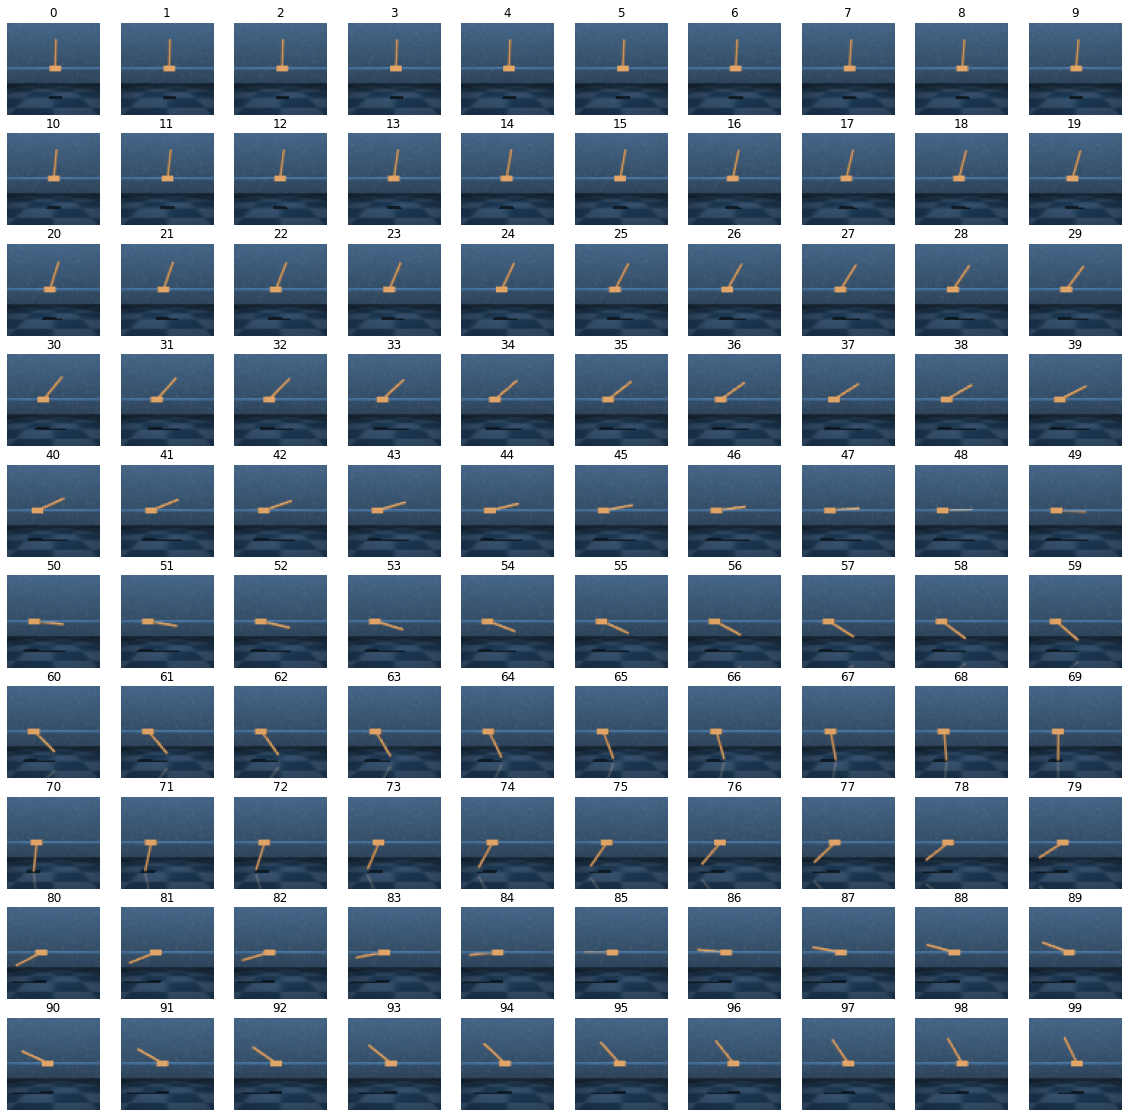

In [126]:
traj_idx = np.random.randint(1000)

n = 100
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))

for i in range(n):
    state = expl_buffer.states[traj_idx][i]
    obs = dmc2gym_utils.get_state_from_qpos(env, state[:2])
    print(i, np.abs(np.sin(expl_buffer.states[traj_idx][i][1]) - np.sin(env.goals['state'][0][1])))
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

## Train RNet

In [18]:
cfg.rnet.model.remove_velocity = True

model = RNetModel(cfg.rnet.model, space_info)
model = model.to(device)

print(model)

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [50]:
cfg.rnet.train.num_epochs = 10

stats = train(cfg.rnet.train, model, dataset, device)

rnet epoch 0 - train loss 0.08,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 1 - train loss 0.08,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 2 - train loss 0.08,  acc 0.98 - val loss 0.08,  acc 0.98
rnet epoch 3 - train loss 0.07,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 4 - train loss 0.07,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 5 - train loss 0.07,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 6 - train loss 0.07,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 7 - train loss 0.07,  acc 0.98 - val loss 0.07,  acc 0.98
rnet epoch 8 - train loss 0.07,  acc 0.98 - val loss 0.06,  acc 0.98
rnet epoch 9 - train loss 0.07,  acc 0.98 - val loss 0.06,  acc 0.98


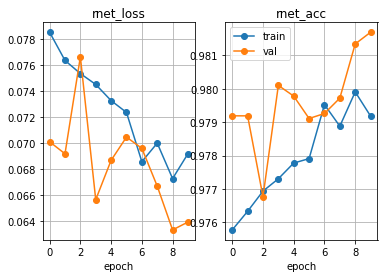

In [51]:
epochs = list(stats.keys())

new_stats = {}
for epoch in epochs:
    for phase in stats[epoch]:
        if not phase in new_stats:
            new_stats[phase] = {}
        for stat, v in stats[epoch][phase].items():
            if not stat in new_stats[phase]:
                new_stats[phase][stat] = []
            if isinstance(v, torch.Tensor):
                v = v.item()
            new_stats[phase][stat].append(v)

fig, ax = plt.subplots(1, 2)
i = 0
for stat in ['rnet_loss', 'rnet_acc']:
    for phase in ['train', 'val']:
        ax[i].plot(epochs, new_stats[phase][stat], label=phase, marker='o')
    ax[i].grid()
    ax[i].set_title(stat)
    ax[i].set_xlabel('epoch')
    i += 1
ax[1].legend()
plt.show()

In [52]:
model.to(device)
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [53]:
embs = embed_expl_buffer(expl_buffer, model, device)
expl_buffer.set_embs(embs)

embed exploration buffer: 100%|██████████| 16045/16045 [00:14<00:00, 1097.40it/s]


## Build Memory

In [54]:
cfg.rnet.memory.directed = True

In [55]:
memory = RNetMemory(cfg.rnet.memory, space_info, model.feat_size, device)

memory.build(model, expl_buffer)

Updating Memory: 100%|██████████| 16045/16045 [06:06<00:00, 43.72it/s]

num obs seen: 160948
memory_len : 77


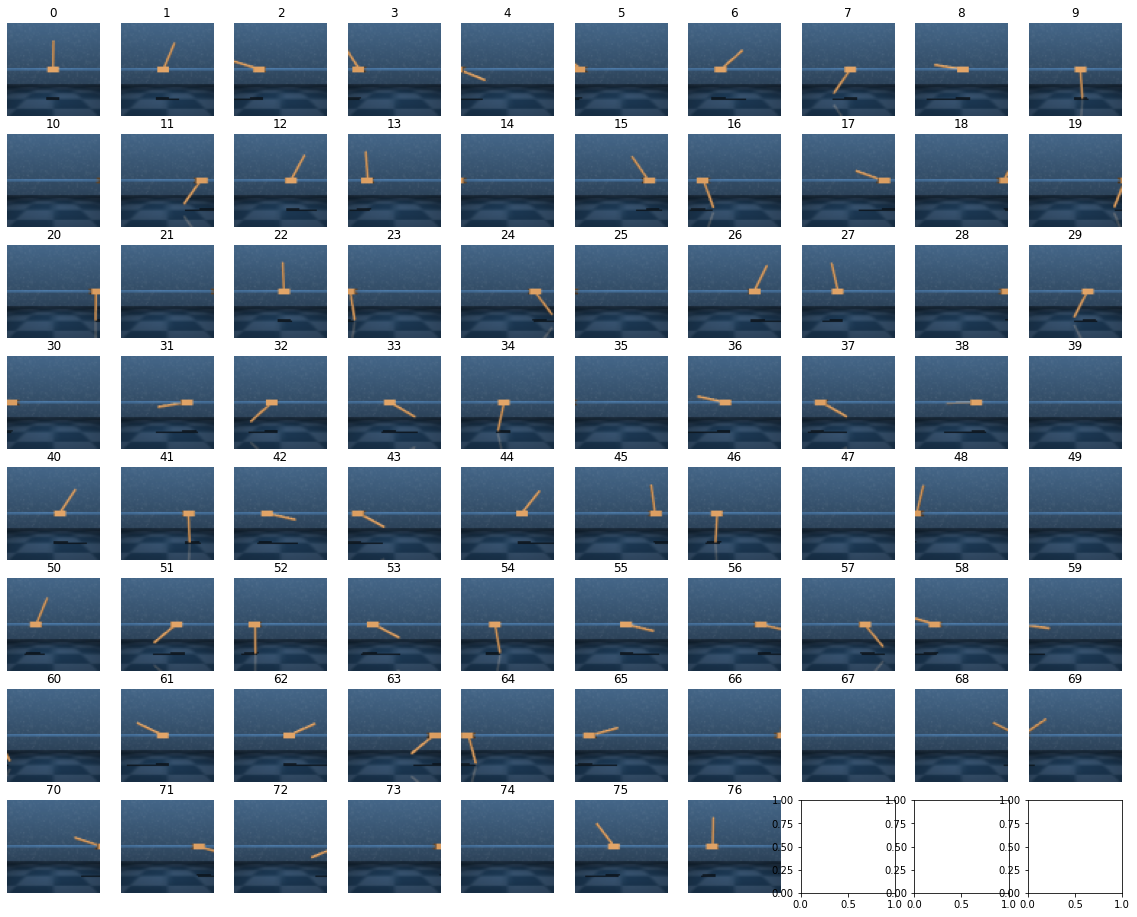

In [56]:
n = len(memory)
num_cols = 10
num_rows = n // num_cols + int(n % num_cols != 0)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))

for i in range(n):
    state = memory.states[i]
    obs = dmc2gym_utils.get_state_from_qpos(env, state[:2])
    img = env.get_image_from_obs(obs)
    ax[i // num_cols, i % num_cols].imshow(img.transpose((1, 2, 0)))
    ax[i // num_cols, i % num_cols].axis('off')
    ax[i // num_cols, i % num_cols].set_title(str(i))
plt.show()

In [57]:
nn = memory.compute_NN(expl_buffer.embs, model)
expl_buffer.embs = expl_buffer.embs.to("cpu")
memory.set_nn(nn)

computing NN: 100%|██████████| 16045/16045 [00:17<00:00, 904.32it/s]


In [58]:
memory.compute_edges(model)

computing edges: 100%|██████████| 16045/16045 [04:47<00:00, 55.80it/s]


out


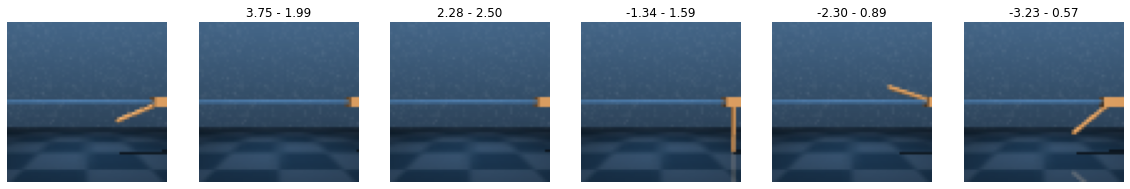

in


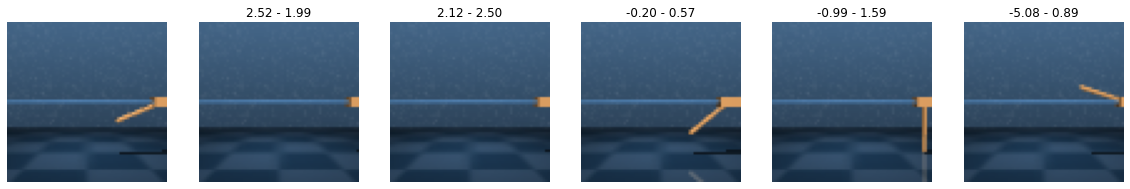

In [111]:
def show_kNN(env, model, memory, obs, state, k=9):
    obs_torch = torch.from_numpy(obs).unsqueeze(0).float().to(device)
    e = model.get_embedding(obs_torch)
    out_o = memory.compare_embeddings(e, model)
    out_i = memory.compare_embeddings(e, model, incoming_dir=True)
    idx_o =  torch.argsort(out_o, descending=True)
    idx_i =  torch.argsort(out_i, descending=True)
    
    print("out")
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = dmc2gym_utils.get_state_from_qpos(env, state[:2])
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx_o[i]]
        obs = dmc2gym_utils.get_state_from_qpos(env, state_NN[:2])
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out_o[idx_o[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()
    
    
    print("in")
    fig, ax = plt.subplots(1, k + 1, figsize=(20, 5))
    obs = dmc2gym_utils.get_state_from_qpos(env, state[:2])
    img = env.get_image_from_obs(obs)
    ax[0].imshow(img.transpose((1, 2, 0)))
    ax[0].axis('off')
    for i in range(k):
        state_NN = memory.states[idx_i[i]]
        obs = dmc2gym_utils.get_state_from_qpos(env, state_NN[:2])
        img = env.get_image_from_obs(obs)
        ax[i+1].imshow(img.transpose((1, 2, 0)))
        ax[i+1].set_title(f"{out_i[idx_i[i]]:.2f} - {env.oracle_distance(state[:9], state_NN[:9]):.2f}")
        ax[i+1].axis('off')
    plt.show()
    
obs, i, j = expl_buffer.get_random_obs()

#i, j = 6486, 513
#i, j = 7080, 198
#obs = expl_buffer.get_obs(i, j)
state = expl_buffer.states[i, j]
#state = env.goals['state'][i]
#obs = env.goals['vec_obs'][i]
show_kNN(env, model, memory, obs, state, k=5)

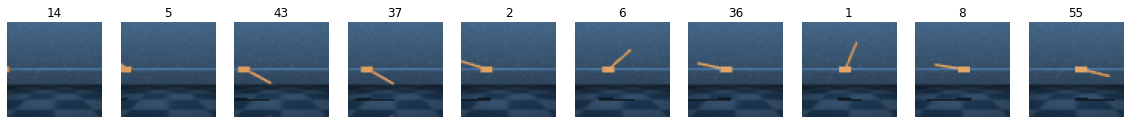

In [119]:
def retrieve_path(pred, i, j):
    if pred[i, j] == -9999:
        return [i]
    path = retrieve_path(pred, i, pred[i, j])
    path.append(j)
    return path

def show_path(env, memory, i, j):
    path = retrieve_path(memory.pred, i, j)
    n = len(path)
    num_cols = n
    num_rows = 1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 *
            num_rows))
    for p in range(n):
        state = memory.states[path[p]]
        obs = dmc2gym_utils.get_state_from_qpos(env, state[:2])
        img = env.get_image_from_obs(obs)
        ax[p].imshow(img.transpose((1, 2, 0)))
        ax[p].axis('off')
        ax[p].set_title(str(path[p]))
    plt.show()
    
i, j = np.random.randint(len(memory)), np.random.randint(len(memory))
#j=42
show_path(env, memory, i, j)

In [64]:
import matplotlib.image as mpimg
import numpy as np
import networkx as nx



In [66]:
for i in range(memory.adj_matrix.shape[0]):
    memory.adj_matrix[i, i] = False

g = nx.DiGraph()
for i in range(memory.adj_matrix.shape[0]):
    g.add_node(i, image=env.get_image_from_obs(
        dmc2gym_utils.get_state_from_qpos(env, memory.states[i, :2])
    ).transpose(1, 2, 0))

for i in range(memory.adj_matrix.shape[0]):
    for j in range(memory.adj_matrix.shape[1]):
        if memory.adj_matrix[i, j]:
            g.add_edge(i, j)

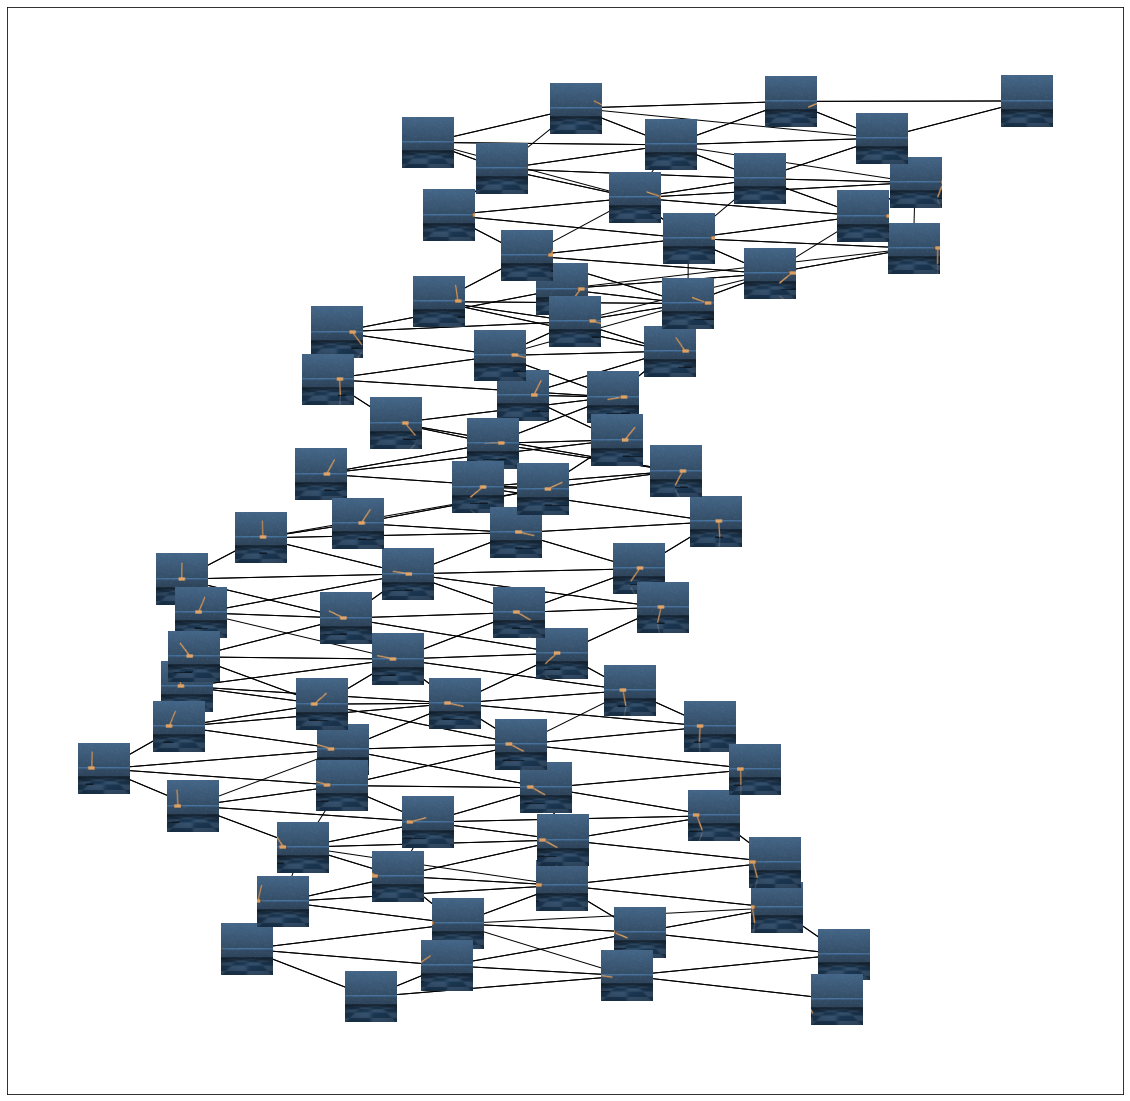

In [80]:
subg = g

pos = nx.kamada_kawai_layout(subg)
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw_networkx_edges(
    subg,
    ax=ax,
    pos=pos,
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.075
icon_center = icon_size / 2.0

# Add the respective image to each node
for n in subg.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot icon
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(subg.nodes[n]["image"])
    a.axis("off")
#plt.show()
plt.savefig("graph_cartpole.pdf")

## Save

In [85]:
exp_name = 'cartpole_thresh2-velo'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)

save(save_dir, model, memory)

Saving rnet objects to  /checkpoint/linamezghani/offline-gcrl/rnet/cartpole_thresh2-velo
